In [17]:
import os
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('ggplot')

In [18]:
refitData = True
doVerbosePlot = False

In [19]:
dataFiles = os.listdir('3_virilizationplots/data')
dataFiles = ['3_virilizationplots/data/' + e for e in dataFiles if e.endswith('.txt')]
#gte binwidths
bws = [float(e.split('_bw')[1].split('_')[0]) for e in dataFiles]
#sort
indSorted = np.argsort(bws)
dataFiles = [dataFiles[i] for i in indSorted]
bws = [bws[i] for i in indSorted]
#sort by binwidth
bwSorted = {}
for i in range(len(bws)):
    if bws[i] not in bwSorted:
        bwSorted[bws[i]] = []
    bwSorted[bws[i]].append(dataFiles[i])
bwrsSorted = {k: [] for k in bwSorted}
for k in bwSorted:
    rsSorted = {}
    for i in range(len(bwSorted[k])):
        rs = float(bwSorted[k][i].split('_rs')[1].split('_')[0])
        if rs not in rsSorted:
            rsSorted[rs] = []
        rsSorted[rs].append(bwSorted[k][i])
    rs = [r for r in rsSorted]
    indSorted = np.argsort(rs)
    rsSorted = {rs[i]: rsSorted[rs[i]] for i in indSorted}
    for rs in rsSorted:
        bwrsSorted[k].append(rsSorted[rs])
bwrsSorted_fit = deepcopy(bwrsSorted)
bwrsSorted_data = deepcopy(bwrsSorted)
for k in bwrsSorted_fit:
    for i in range(len(bwrsSorted_fit[k])):
        if len(bwrsSorted_fit[k][i]) == 2:
            if '_data' in bwrsSorted_fit[k][i][0]:
                bwrsSorted_fit[k][i].pop(0)
            elif '_data' in bwrsSorted_fit[k][i][1]:
                bwrsSorted_fit[k][i].pop(1)
        else:
            print("skipping datapoint: ",bwrsSorted_fit[k][i])
        if len(bwrsSorted_data[k][i]) == 2:
            if '_fit' in bwrsSorted_data[k][i][0]:
                bwrsSorted_data[k][i].pop(0)
            elif '_fit' in bwrsSorted_data[k][i][1]:
                bwrsSorted_data[k][i].pop(1)
        else:
            print("skipping datapoint...")

#read fitdata
fitData = {}
for k in bwrsSorted_fit:
    fitData[k] = {}
    for i in range(len(bwrsSorted_fit[k])):
        rs = float(bwrsSorted_fit[k][i][0].split('_rs')[1].split('_')[0])
        fitData[k][rs] = {}
        dataArr = np.loadtxt(bwrsSorted_fit[k][i][0],skiprows=1)
        for j,point in enumerate(['a','b','a_sigma','b_sigma']):
            fitData[k][rs][point] = dataArr[j]
        fitData[k]['meta'] = {}
        bs = float(bwrsSorted_fit[k][i][0].split('bs')[1].split('_')[0])
        fitData[k]['meta']['bs'] = bs
    
"""for k in fitData:
    print(f'{k}: {fitData[k]}')"""
    
#read data
data = {}
for k in bwrsSorted_data:
    data[k] = {}
    for i in range(len(bwrsSorted_data[k])):
        rs = float(bwrsSorted_data[k][i][0].split('_rs')[1].split('_')[0])
        data[k][rs] = {}
        dataArr = np.loadtxt(bwrsSorted_data[k][i][0],skiprows=1)
        data[k][rs]['data'] = dataArr
        data[k]['meta'] = {}
        bs = float(bwrsSorted_data[k][i][0].split('bs')[1].split('_')[0])
        data[k]['meta']['bs'] = bs

"""for k in data:
    print(f'{k}: {data[k]}')"""

linear = lambda x, a, b: a*x+b
linear_notlog = lambda x, a, b: np.power(10,(a*x+b))

if refitData:
    #fit data
    for k in data:
        for rs in data[k]:
            if rs == 'meta':
                continue
            bs = data[k]['meta']['bs']
            x = data[k][rs]['data'][:,0]
            y = data[k][rs]['data'][:,1]
            y /= np.sum(y)
            sigma = data[k][rs]['data'][:,2]
            #find linear regime
            peakInd = np.argmax(y)
            peakX = x[peakInd]
            thresholdX = (x[-1]*1.5 + peakX)/2.5
            thresholdInd = np.argmin(np.abs(x - thresholdX))
            x_linearReg = x[thresholdInd:]
            y_linearReg = y[thresholdInd:]
            sigma_linearReg = sigma[thresholdInd:]
            """#log y-axis
            y_linearReg_log = np.log10(y_linearReg)
            sigma_linearReg_log = sigma_linearReg/(y_linearReg_log*np.log(10))
            #remove nan
            ind = np.where(np.isfinite(y_linearReg_log))
            x_linearReg_log = x_linearReg[ind]
            y_linearReg_log = y_linearReg_log[ind]
            sigma_linearReg_log = sigma_linearReg_log[ind]"""
            #remove zero-sigmas
            zeroInds = np.where(sigma_linearReg == 0)
            if len(zeroInds[0]) > 0:
                newSigma = np.min(sigma_linearReg[np.where(sigma_linearReg != 0)])
                sigma_linearReg[zeroInds] = newSigma
            #fit
            #popt, pcov = curve_fit(linear, x_linearReg_log, y_linearReg_log, sigma=sigma_linearReg_log, p0=[-80,10])
            popt, pcov = curve_fit(linear_notlog, x_linearReg, y_linearReg, sigma=sigma_linearReg, p0=[-10,10])
            print(f'bw: {k}, rs: {rs}, bs: {bs}, a: {popt[0]}, b: {popt[1]}')
            fitData[k][rs]['a'] = popt[0]
            fitData[k][rs]['b'] = popt[1]
            fitData[k][rs]['a_sigma'] = np.sqrt(pcov[0,0])
            fitData[k][rs]['b_sigma'] = np.sqrt(pcov[1,1])
            fitData[k][rs]['pointCount'] = len(x_linearReg)
            #plot
            if doVerbosePlot:
                plt.figure()
                plt.errorbar(x,y,yerr=sigma,fmt='o',label='data')
                plt.plot(x_linearReg,linear_notlog(x_linearReg,*popt),label='fit')
                plt.yscale('log')
                plt.title(f'bw: {k}, rs: {rs}')
                plt.legend()
                plt.show()
            

bw: 0.07874015748031496, rs: 10.000013420016371, bs: 0.01, a: -90.65642385379262, b: 0.6921523648199509
bw: 0.07874015748031496, rs: 10.789210442046873, bs: 0.01, a: -86.26138954255742, b: 0.6678414010864714
bw: 0.07874015748031496, rs: 11.526068635660376, bs: 0.01, a: -72.73867002667768, b: 0.27523628866378086
bw: 0.07874015748031496, rs: 12.308982500276148, bs: 0.01, a: -75.40050090867425, b: 0.5305729650257766
bw: 0.07874015748031496, rs: 13.263836731304743, bs: 0.01, a: -84.56998981952546, b: 1.0015727974149493
bw: 0.07874015748031496, rs: 14.420174996405587, bs: 0.01, a: -58.7500366941345, b: -0.5622579093743915
bw: 0.07874015748031496, rs: 15.670255093281732, bs: 0.01, a: -75.06602158365531, b: 0.706267001253809
bw: 0.07874015748031496, rs: 17.178440663968992, bs: 0.01, a: -58.098066990713264, b: 0.12036483886324298
bw: 0.07874015748031496, rs: 18.9955081978936, bs: 0.01, a: -52.634346706798596, b: -0.19436453491613054
bw: 0.07874015748031496, rs: 24.04550760148465, bs: 0.01, a: 

c:\Users\thorb\miniconda3\envs\uni\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


bw=0.07874015748031496, rs=10.000013420016371, bs=0.01
a:  -90.65642385379262
b:  0.6921523648199509
$\sigma_a$:  2.4267069086238253
$\sigma_b$:  0.1420899922305592
bw=0.07874015748031496, rs=10.789210442046873, bs=0.01
a:  -86.26138954255742
b:  0.6678414010864714
$\sigma_a$:  5.198252601167671
$\sigma_b$:  0.34259923358237143
bw=0.07874015748031496, rs=11.526068635660376, bs=0.01
a:  -72.73867002667768
b:  0.27523628866378086
$\sigma_a$:  0.9187699630591611
$\sigma_b$:  0.0647873666103263
bw=0.07874015748031496, rs=12.308982500276148, bs=0.01
a:  -75.40050090867425
b:  0.5305729650257766
$\sigma_a$:  1.3718632044043941
$\sigma_b$:  0.10150674834078699
bw=0.07874015748031496, rs=13.263836731304743, bs=0.01
a:  -84.56998981952546
b:  1.0015727974149493
$\sigma_a$:  6.400443943440674
$\sigma_b$:  0.442859170457595
bw=0.07874015748031496, rs=14.420174996405587, bs=0.01
a:  -58.7500366941345
b:  -0.5622579093743915
$\sigma_a$:  3.6030787239376685
$\sigma_b$:  0.2793681420423655
bw=0.07874

C:\Users\thorb\AppData\Local\Temp\ipykernel_20512\2983105129.py:36: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(((1 - 10**(a + b)/(a*np.log(10)))**Nbins_JWST)**2*Nbins_JWST**2*(-10**(a + b)/a + 10**(a + b)/(a**2*np.log(10)))**2*a_sigma**2/(1 - 10**(a + b)/(a*np.log(10)))**2 + ((1 - 10**(a + b)/(a*np.log(10)))**Nbins_JWST)**2*Nbins_JWST**2*(10**(a + b))**2*b_sigma**2/(a**2*(1 - 10**(a + b)/(a*np.log(10)))**2))
C:\Users\thorb\AppData\Local\Temp\ipykernel_20512\2983105129.py:31: RuntimeWarning: invalid value encountered in double_scalars
  prop = 1-(1-prop)**Nbins_JWST


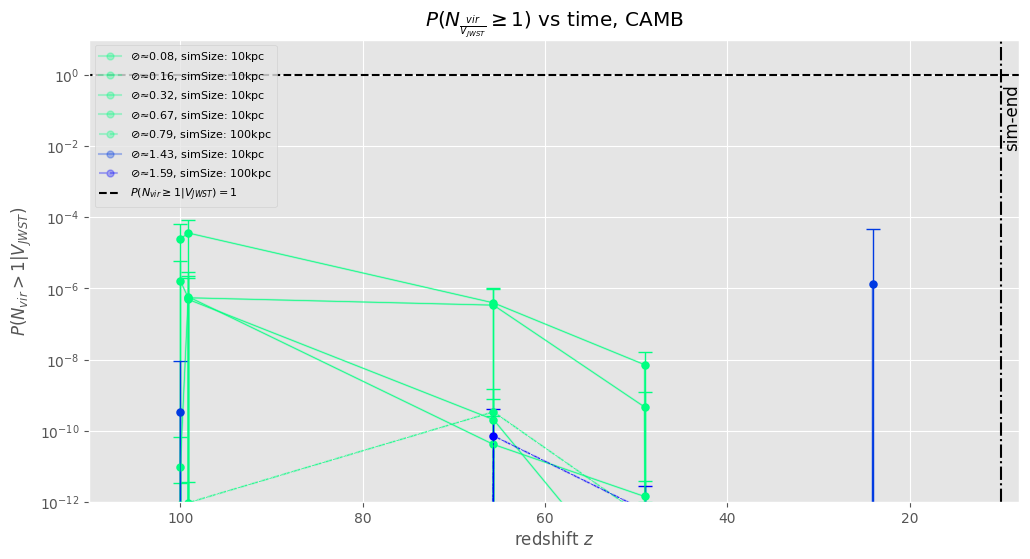

In [25]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
#plot x-axis in opposite direction
ax.invert_xaxis()
#plot data
linear_notlog = lambda x, a, b: np.power(10,(a*x+b))
sets = {}
lowerBound = 1e-12
for i,k in enumerate(fitData):
    bw = k
    bs = fitData[k]['meta']['bs']
    sets[k] = []
    withinBounds = False
    for rs in fitData[k]:
        if rs == 'meta':
            continue
        print(f'bw={bw}, rs={rs}, bs={bs}')
        a = fitData[k][rs]['a']
        print("a: ", a)
        b = fitData[k][rs]['b']
        print("b: ", b)
        a_sigma = fitData[k][rs]['a_sigma']
        print(r'$\sigma_a$: ', a_sigma)
        b_sigma = fitData[k][rs]['b_sigma']
        print(r'$\sigma_b$: ', b_sigma)
        x = np.linspace(0,1.1,100)
        y = linear_notlog(x,a,b)
        #plt.plot(x,y,label=f'bw={bw}, rs={rs}, bs={bs}')
        prop = -10**(a + b)/(a*np.log(10))
        Nbins_JWST = (1/bw)**3*0.030052932#(bs/bw)**3*(1/bs)**3*0.030052932
        prop = 1-(1-prop)**Nbins_JWST
        #eq = 1-(1-(-10**(a + b)/(a*np.log(10))))**Nbins_JWST
        #D_a(eq)**2 = ((1 - 10**(a + b)/(a*ln(10)))**N)**2*N**2*(-10**(a + b)/a + 10**(a + b)/(a**2*ln(10)))**2*a_sigma**2/(1 - 10**(a + b)/(a*ln(10)))**2
        #D_b(eq)**2 = ((1 - 10**(a + b)/(a*ln(10)))**N)**2*N**2*(10**(a + b))**2*b_sigma**2/(a**2*(1 - 10**(a + b)/(a*ln(10)))**2)
        #sqrt(D_a(eq)**2 + D_b(eq)**2) = sqrt(((1 - 10**(a + b)/(a*ln(10)))**N)**2*N**2*(-10**(a + b)/a + 10**(a + b)/(a**2*ln(10)))**2*a_sigma**2/(1 - 10**(a + b)/(a*ln(10)))**2 + ((1 - 10**(a + b)/(a*ln(10)))**N)**2*N**2*(10**(a + b))**2*b_sigma**2/(a**2*(1 - 10**(a + b)/(a*ln(10)))**2))
        sigma = np.sqrt(((1 - 10**(a + b)/(a*np.log(10)))**Nbins_JWST)**2*Nbins_JWST**2*(-10**(a + b)/a + 10**(a + b)/(a**2*np.log(10)))**2*a_sigma**2/(1 - 10**(a + b)/(a*np.log(10)))**2 + ((1 - 10**(a + b)/(a*np.log(10)))**Nbins_JWST)**2*Nbins_JWST**2*(10**(a + b))**2*b_sigma**2/(a**2*(1 - 10**(a + b)/(a*np.log(10)))**2))
        #plt.plot(rs,prop,'o',label=f'bw={bw}, rs={rs}, bs={bs}',color=colors[i])
        if a < -0.1 and fitData[k][rs]['pointCount'] > 2:
            sets[k].append([rs,prop,bs,sigma])
        else:
            print('point fit failed')
        if prop > lowerBound:
            withinBounds = True
    if not withinBounds:
        sets.pop(k)
    
maxVal = 0
linestyles = {
    0.01: '-',
    0.1: '--',
    1: ':',
}
colormap = plt.cm.winter

maxØ = np.log10(max([k for k in sets]))

for i,k in enumerate(sets):
    sets[k] = np.array(sets[k])
    bs = sets[k][:,2][0]
    lineStyle = linestyles[bs]
    color = colormap(1-np.log10(k)/maxØ)
    plt.plot(sets[k][:,0],sets[k][:,1],label=r'$\oslash$' + f'≈{round(k,2)}, simSize: {int(bs*1000)}kpc',color=color,linestyle=lineStyle,alpha=0.3,marker='o',markersize=5)
    plt.errorbar(sets[k][:,0],sets[k][:,1],yerr=sets[k][:,3],color=color,capsize=5,marker='o',markersize=5,linewidth=0.5,elinewidth=1,linestyle=lineStyle)
    if np.max(sets[k][:,1]) > maxVal:
        maxVal = np.max(sets[k][:,1])
ax.set_yscale('log')
ax.set_ylim(lowerBound,10)
#plot dashed line at 1
plt.plot([0,200],[1,1],'--',color='black',label=r'$P(N_{vir}\geq1|V_{JWST})=1$')
plt.title(r'$P(N_{\frac{vir}{V_{JWST}}}\geq1)$ vs time, CAMB')
plt.xlim(110,8)
plt.xlabel(r'redshift $z$')
plt.ylabel(r'$P(N_{vir}>1|V_{JWST})$')
plt.axvline(10,linestyle='-.',color='black')
plt.text(9.8,0.01,'sim-end',rotation=90,fontsize=12)
plt.legend(loc='upper left',prop={"size": 8})
plt.savefig('virilizationrate.png')
plt.show()
        